('labels ', [[1], [1], [1], [1], [1], [0], [0], [0], [0], [0]])


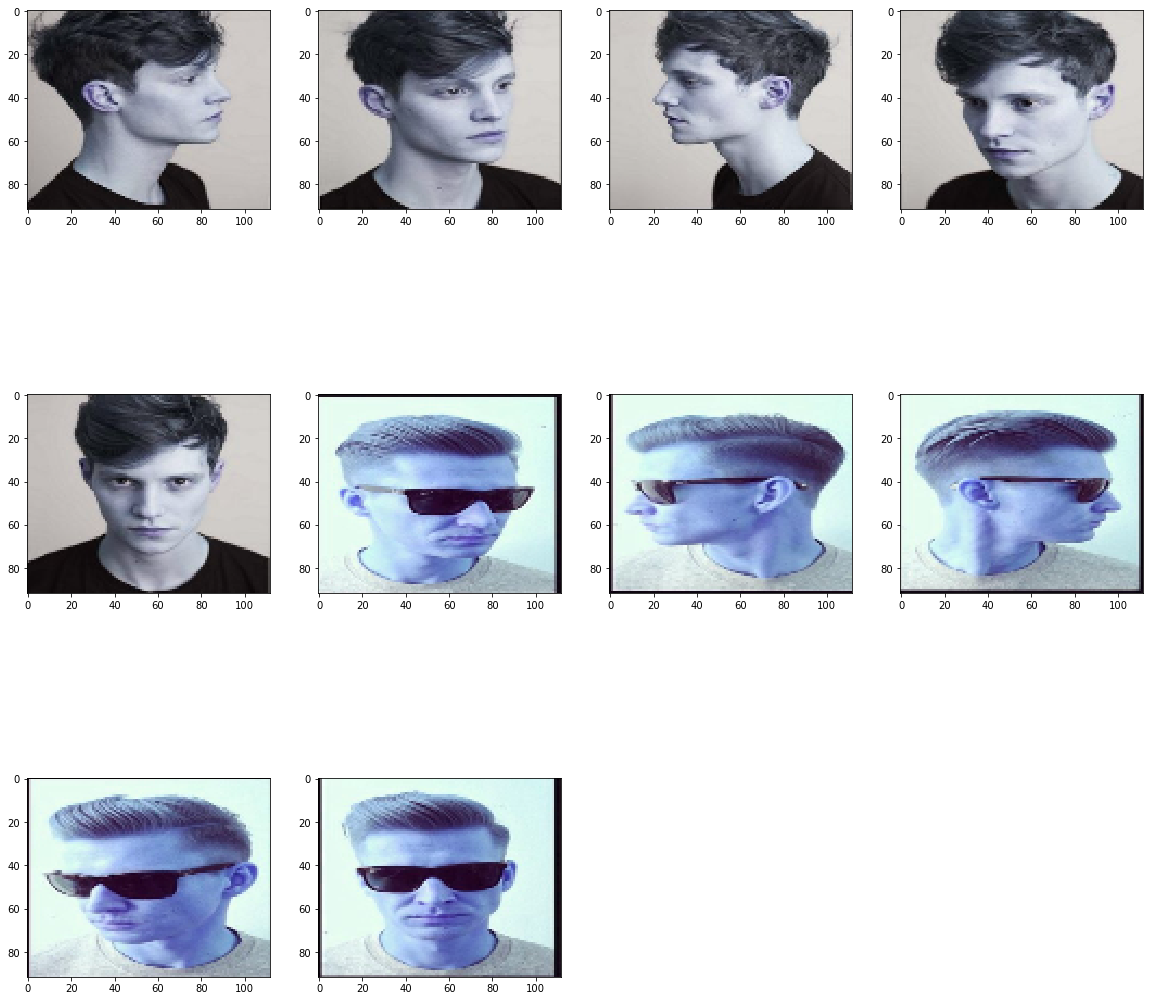

(10, 92, 112, 3)


In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np




# loading positive images and labels


images1=[]    # To store list of images

label=[]      # To Store Labels

files=glob.glob("/home/shashank/face_recogn_1/*.jpg")  # reads all the file_names from the specified folder into  files[] list 

for file in files:               #for loop for reading images into images1[] list and appends label of the image into label_positive[] list
    image1=cv2.imread(file) 
    resized_image = cv2.resize(image1, (112, 92))
    images1.append(resized_image)      
    label.append([1])

    
#plt.imshow(images1[1])       #displaying the first image of the list images1[]
#plt.show()



#-------------------------------------loading of positive images is done ----------------------------------------------------


#-------------------------------------loading  negative images and labels----------------------------------------------------

files=glob.glob("/home/shashank/face_recogn_2/*.jpg")  #reads all the file_names in the specified folder into  files[] list 

#print files     # prints all file names in the folder
#print len(files)   # prints number of files have been red

for file in files:               #for loop for reading images into images1[] list and appends label of the image into label_positive[] list
    image1=cv2.imread(file) 
    resized_image = cv2.resize(image1, (112, 92))
    images1.append(resized_image)      
    label.append([0])

    
#plt.imshow(images1[16])       #displaying the first image of the list images1[]
#plt.show()

print(("labels ",label))


#-------------------------------------loading of Negative images is done ----------------------------------------------------


images2=np.array(images1)

plt.figure(figsize=(20,20))
columns = 4
for i in range(10):
    plt.subplot(10 / columns + 1, columns, i + 1)
    plt.imshow(images2[i,:,:,:])
plt.show()   




#images2=np.array(images1)
labels=np.array(label)
print((images2.shape))

In [2]:
print (images2.shape[1:4])

(92, 112, 3)


In [3]:
x = tf.placeholder(tf.float32,shape=(None,images2.shape[1],images2.shape[2],images2.shape[3]))   # Tenssorflow container to hold input data 
y = tf.placeholder(tf.float32, shape=[None,labels.shape[1]])         # Tensorflow container to hold  target data 


#------------------------------------------First Convolution Layer----------------------------------------------------

W=tf.Variable(tf.random_normal([5, 5, 3, 32]))       # using 32 filters of 5x5 each having dimension 3    
b=tf.Variable(tf.random_normal([32]))                # 1x32 bais values  

x2 = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') 
x2 = tf.nn.bias_add(x2, b)
conv_output=tf.nn.relu(x2)
maxpool_output=tf.nn.max_pool(conv_output,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # New image 56x46 


#------------------------------------------Second Convolution Layer----------------------------------------------------

W1=tf.Variable(tf.random_normal([3, 3, 32, 64]))  # using 64 filters of 3x3 each having dimension of 32  
b1=tf.Variable(tf.random_normal([64]))            # 64 bais values

x3 = tf.nn.conv2d(maxpool_output, W1, strides=[1, 1, 1, 1], padding='SAME')
x3 = tf.nn.bias_add(x3, b1)
conv_output2=tf.nn.relu(x3)
maxpool_output2=tf.nn.max_pool(conv_output2,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


#-------------------------------------------Third Convolution Layer---------------------------------------------------

W2=tf.Variable(tf.random_normal([3, 3, 64,16]))  # using 16 filters of 3x3 each having dimension of 16 
b2=tf.Variable(tf.random_normal([16]))

x4 = tf.nn.conv2d(maxpool_output2, W2, strides=[1, 1, 1, 1], padding='SAME')
x4 = tf.nn.bias_add(x4, b2)
conv_output3=tf.nn.relu(x4)
maxpool_output3=tf.nn.max_pool(conv_output3,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')




#-------------------------------------------Fully Connected Network---------------------------------------------------


fc_weights1=tf.Variable(tf.truncated_normal([14*12*16, 1024],stddev=0.05))  #   14*12*16 input features 
fc_bias1=tf.Variable(tf.random_normal([1024]))               # 1024 bias   

fc_weights2=tf.Variable(tf.random_normal([1024, 2048]))      # Hidden Layer accept 1024 
fc_bias2=tf.Variable(tf.random_normal([2048]))               #2048 bias

fc_weights3=tf.Variable(tf.random_normal([2048, 128]))       
fc_bias3=tf.Variable(tf.random_normal([128]))

fc_weights5=tf.Variable(tf.random_normal([128, 8]))
fc_bias5=tf.Variable(tf.random_normal([8]))

fc_weights4=tf.Variable(tf.random_normal([8,1]))
fc_bias4=tf.Variable(tf.random_normal([1]))

fc1 = tf.reshape(maxpool_output3, [-1, fc_weights1.get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, fc_weights1), fc_bias1)
fc1 = tf.nn.sigmoid(fc1)


fcl2 = tf.add(tf.matmul(fc1, fc_weights2), fc_bias2)
fcl2=tf.nn.sigmoid(fcl2)


fcl3 = tf.add(tf.matmul(fcl2, fc_weights3), fc_bias3)
fcl3=tf.nn.sigmoid(fcl3)

fcl4 = tf.add(tf.matmul(fcl3, fc_weights5), fc_bias5)
fcl4=tf.nn.sigmoid(fcl4)


# Output, class prediction
out = tf.add(tf.matmul(fcl4, fc_weights4), fc_bias4)
out1=tf.nn.sigmoid(out)

#out1=tf.nn.dropout(out1,0.75)

cost = tf.reduce_mean(( (labels * tf.log(out1)) + ((1 - labels) * tf.log(1.0 - out1)) ) * -1)
#cost=tf.reduce_mean(tf.squared_difference(out1,labels))
#cost=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(labels,tf.float32),logits=out1))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)           



with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
   
    for i in range(1000):
        res,_=sess.run([cost,train_step],feed_dict={x:images2,y:labels})
        if i%100 == 0:
            print (res)
    print ("Validating training dataset")
    res=sess.run([out1],feed_dict={x:images2})
    print(np.round(res)) 
    conv1_output=sess.run([conv_output],feed_dict={x:images2})
    conv2_output=sess.run([conv_output2],feed_dict={x:images2})
    conv3_output=sess.run([conv_output3],feed_dict={x:images2})
    conv1_weights=sess.run([W])
    conv2_weights=sess.run([W1])
    conv3_weights=sess.run([W2])

1.6725
0.0994279
0.0460048
0.0307662
0.0230321
0.0185662
0.015459
0.0131764
0.0115409
0.0102349
Validating training dataset
[[[ 1.]
  [ 1.]
  [ 1.]
  [ 1.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]


(1, 5, 5, 3, 32)


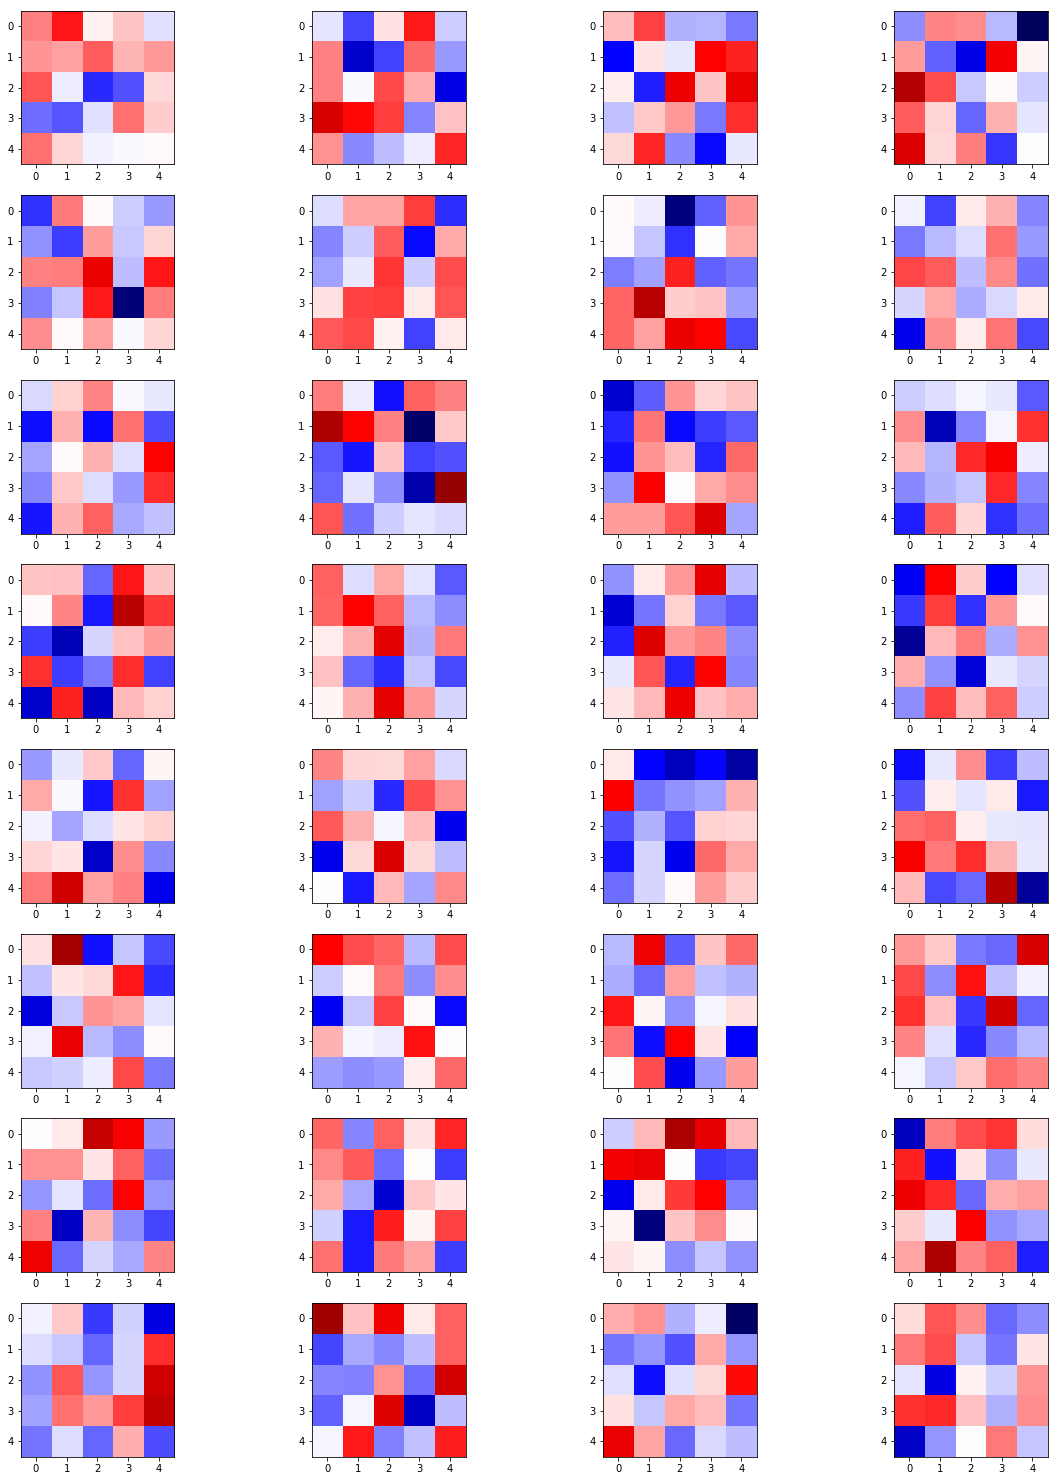

In [4]:
w_min = np.min(conv1_weights)
w_max = np.max(conv1_weights)
outt=np.array(conv1_weights)
print(outt.shape)

plt.figure(figsize=(20,30))
columns = 4
for i in range(32):
    plt.subplot(32 / columns + 1, columns, i + 1)
    plt.imshow(outt[0,:,:,0,i],vmin=w_min, vmax=w_max,interpolation='nearest', cmap='seismic')
plt.show()   

(1, 10, 92, 112, 32)


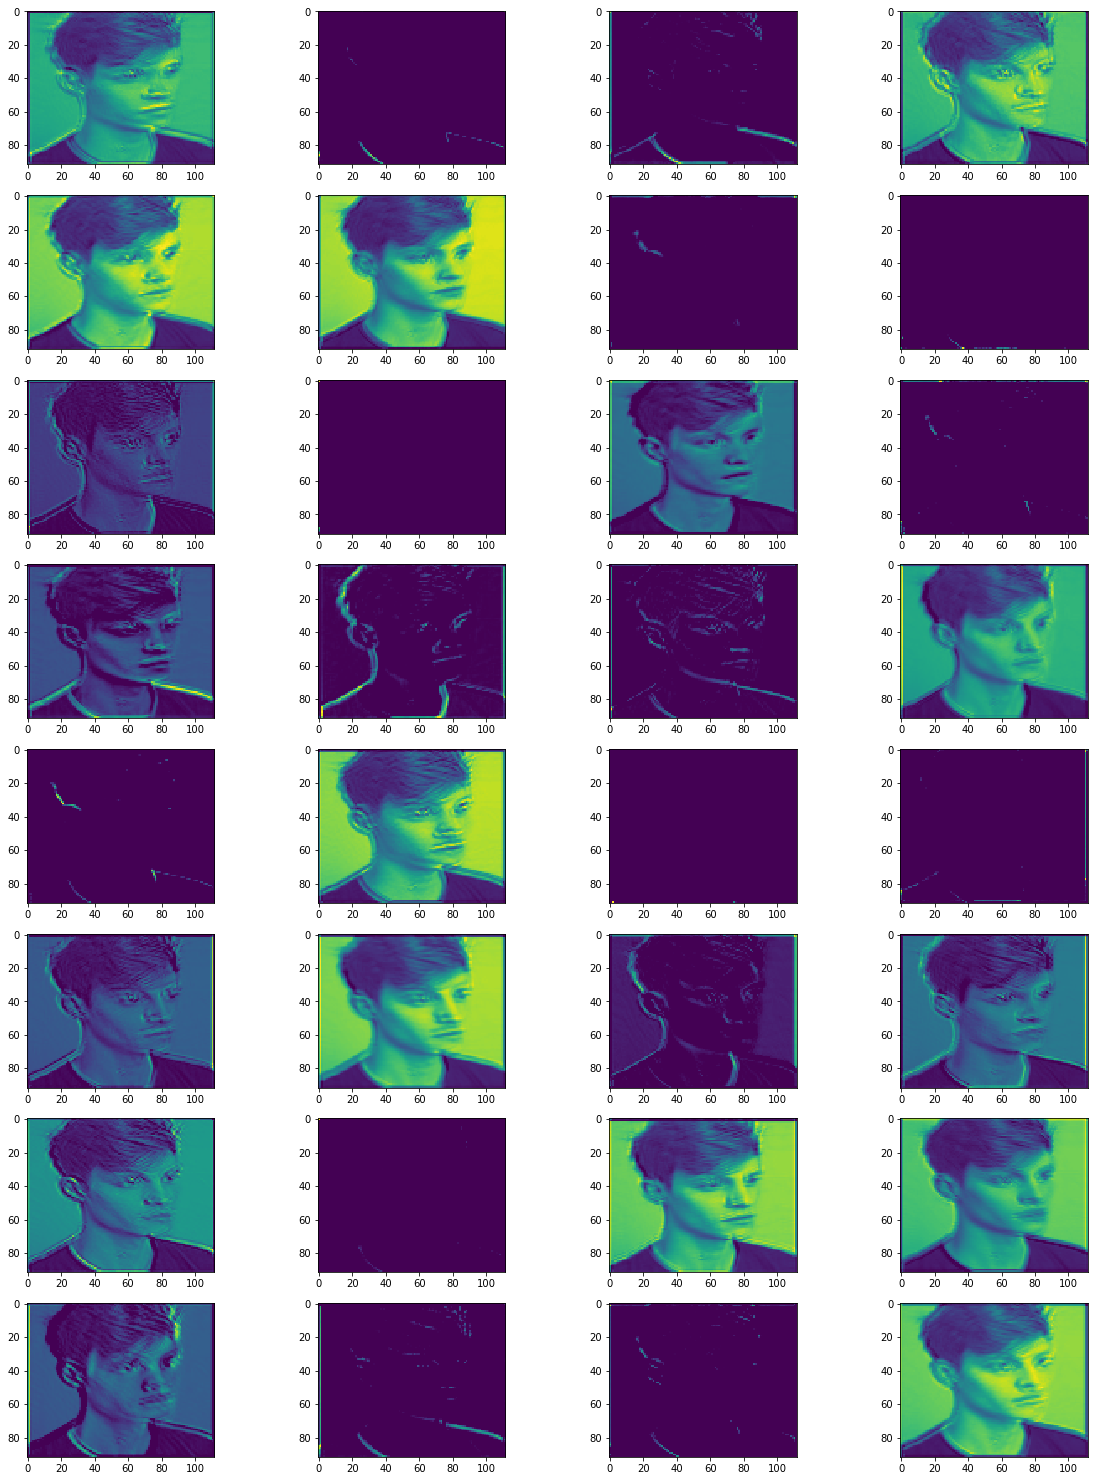

In [5]:
outt=np.array(conv1_output)
print(outt.shape)

plt.figure(figsize=(20,30))
columns = 4
for i in range(32):
    plt.subplot(32 / columns + 1, columns, i + 1)
    plt.imshow(outt[0,1,:,:,i])
plt.show()   


(1, 3, 3, 32, 64)


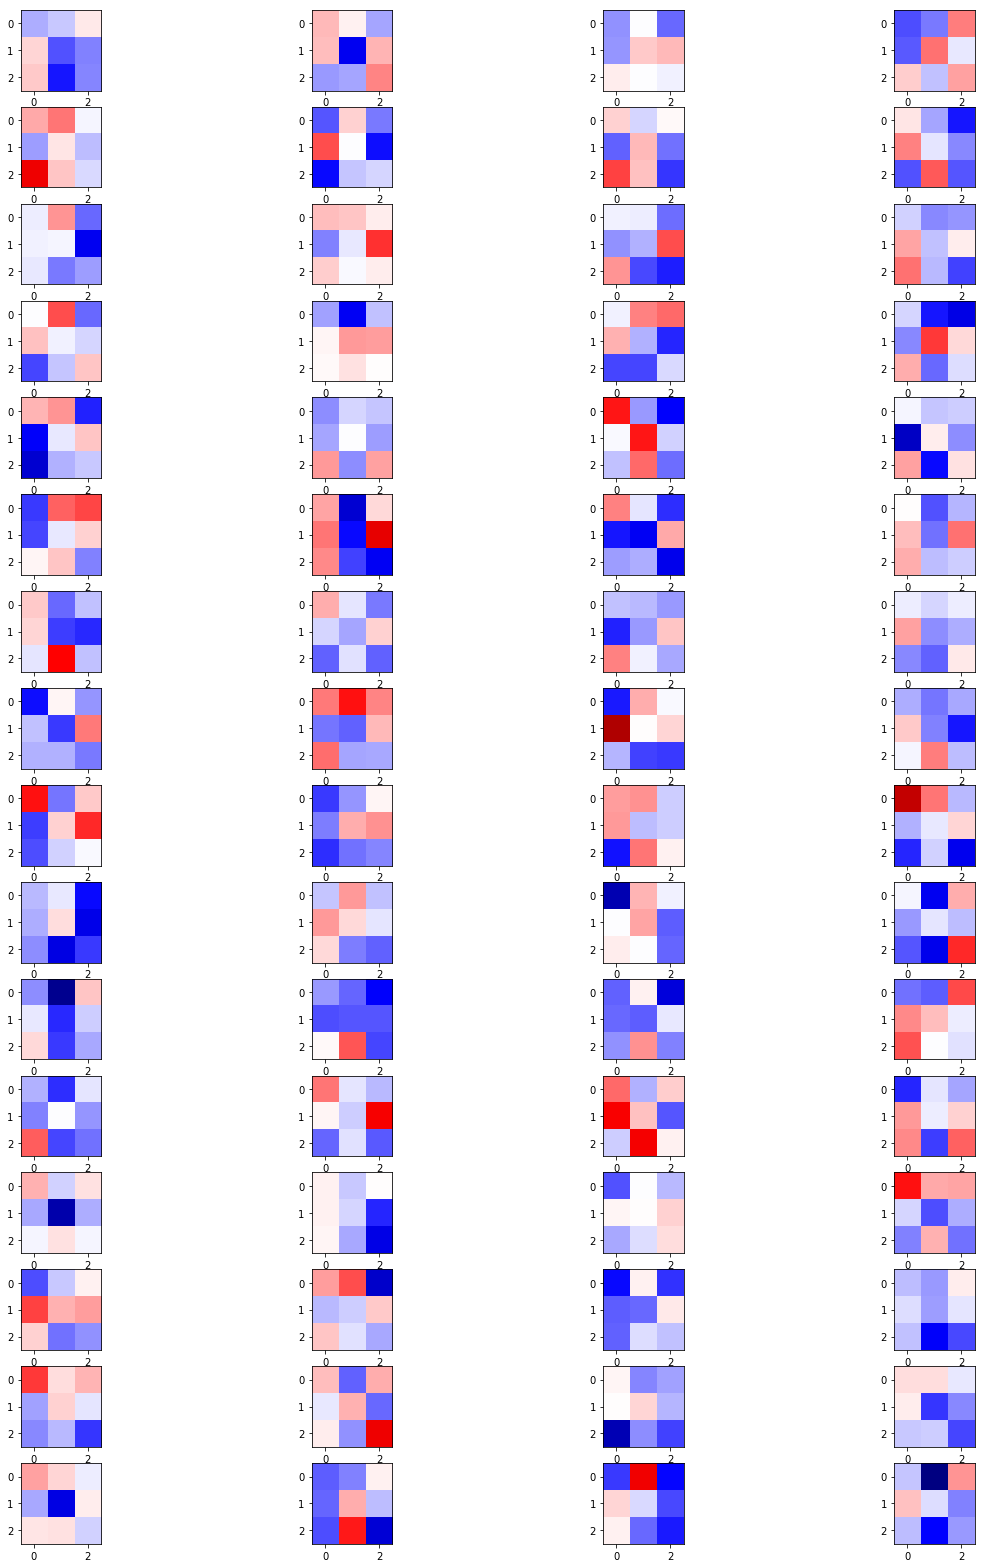

In [6]:
w_min = np.min(conv2_weights)
w_max = np.max(conv2_weights)
outt=np.array(conv2_weights)
print(outt.shape)

plt.figure(figsize=(20,30))
columns = 4
for i in range(64):
    plt.subplot(64 / columns + 1, columns, i + 1)
    plt.imshow(outt[0,:,:,0,i],vmin=w_min, vmax=w_max,interpolation='nearest', cmap='seismic')
plt.show()   

(1, 10, 46, 56, 64)


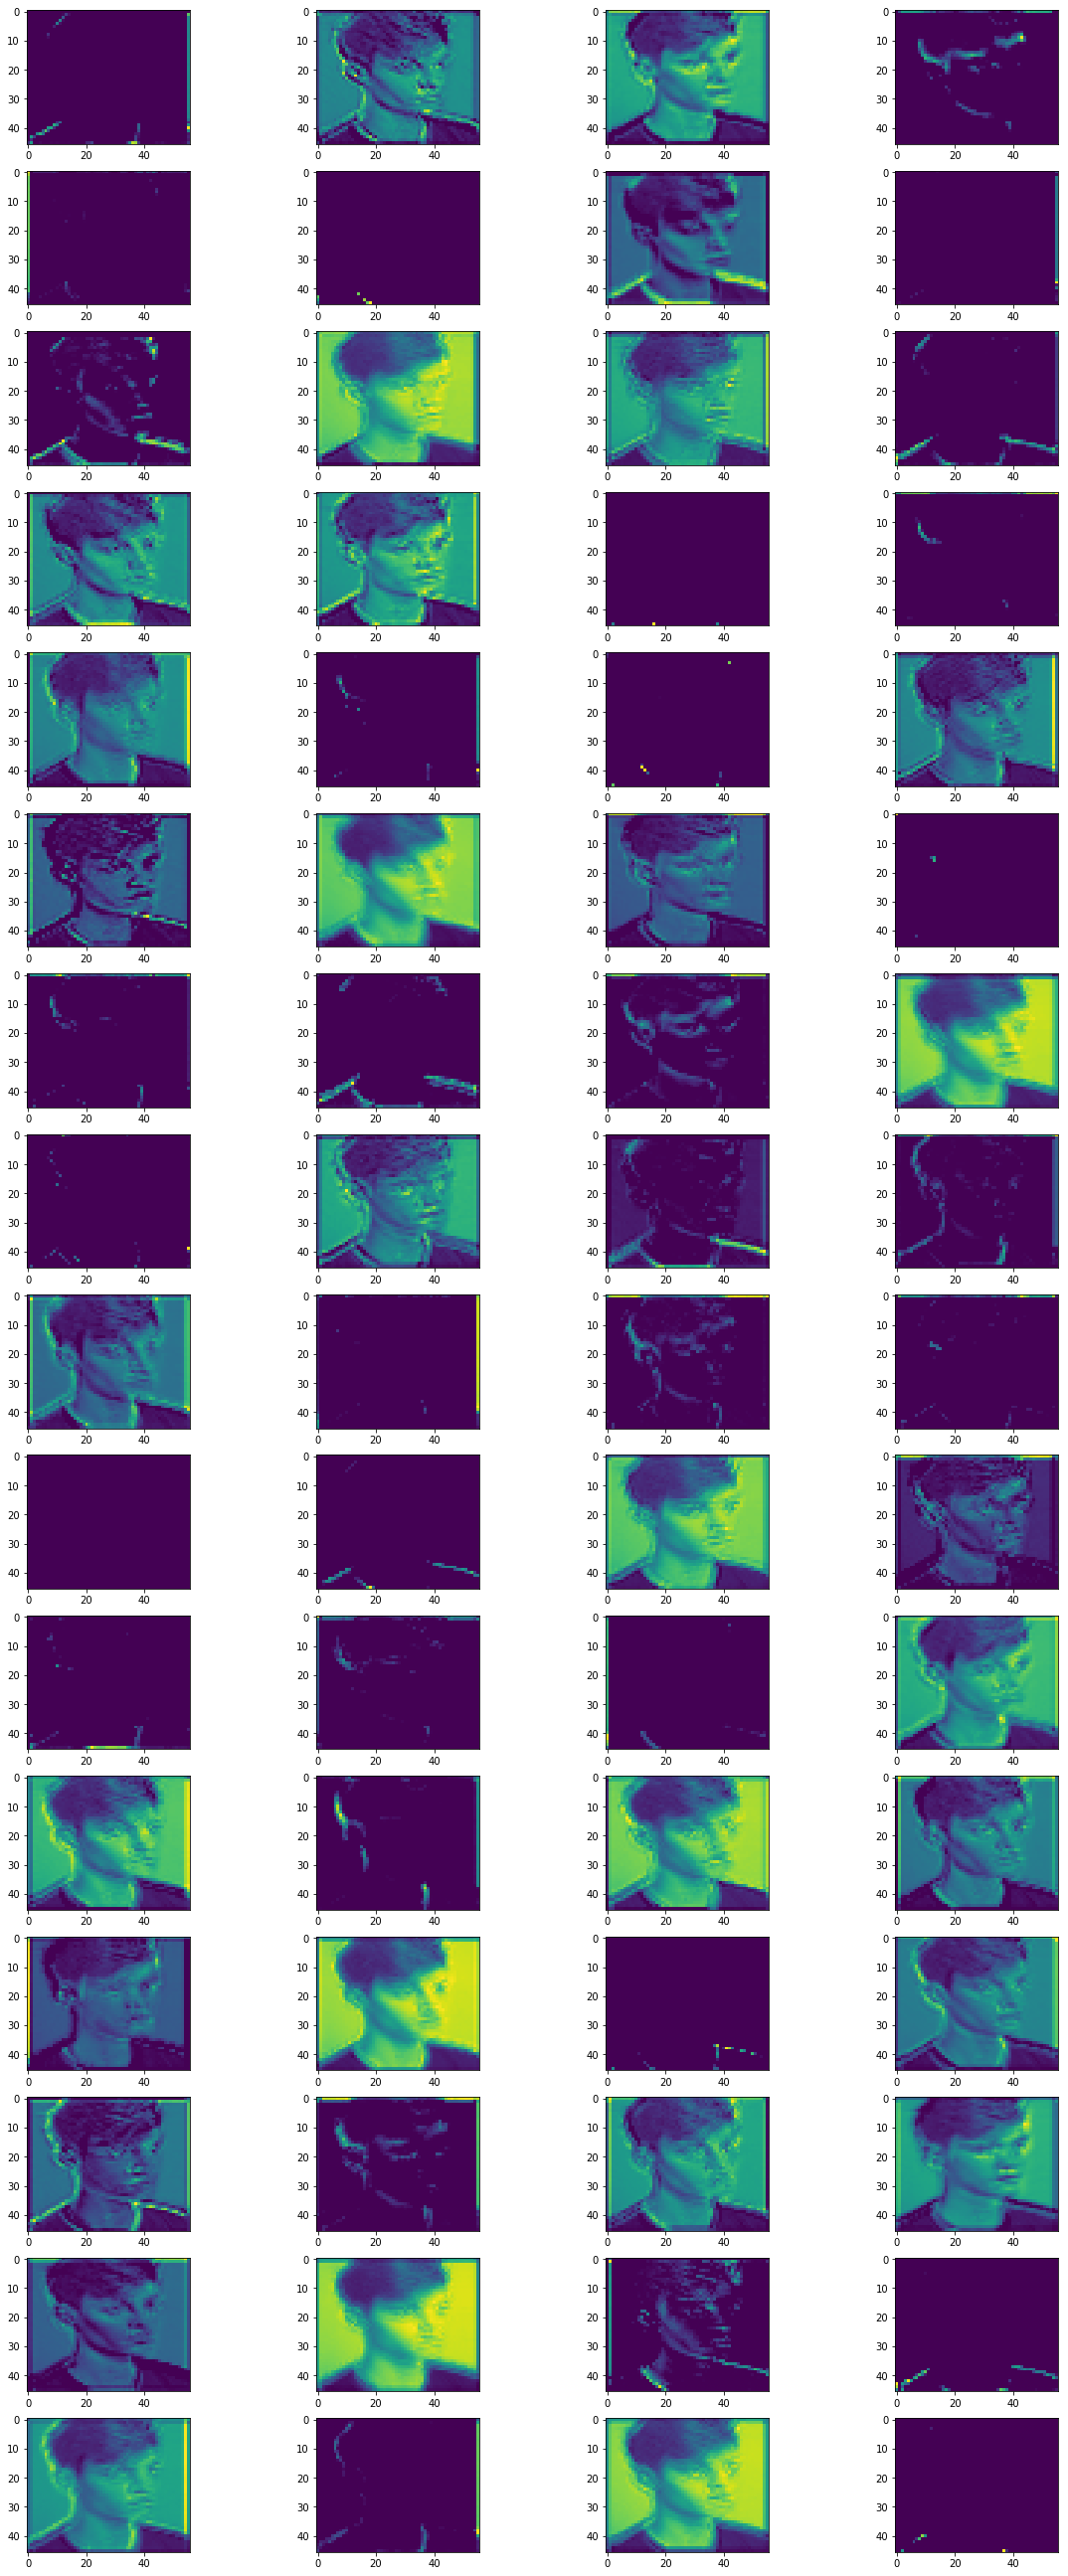

In [7]:
outt=np.array(conv2_output)
print(outt.shape)

plt.figure(figsize=(20,50))
columns = 4
for i in range(64):
    plt.subplot(64 / columns + 1, columns, i + 1)
    plt.imshow(outt[0,1,:,:,i])
plt.show()   

(1, 10, 23, 28, 16)


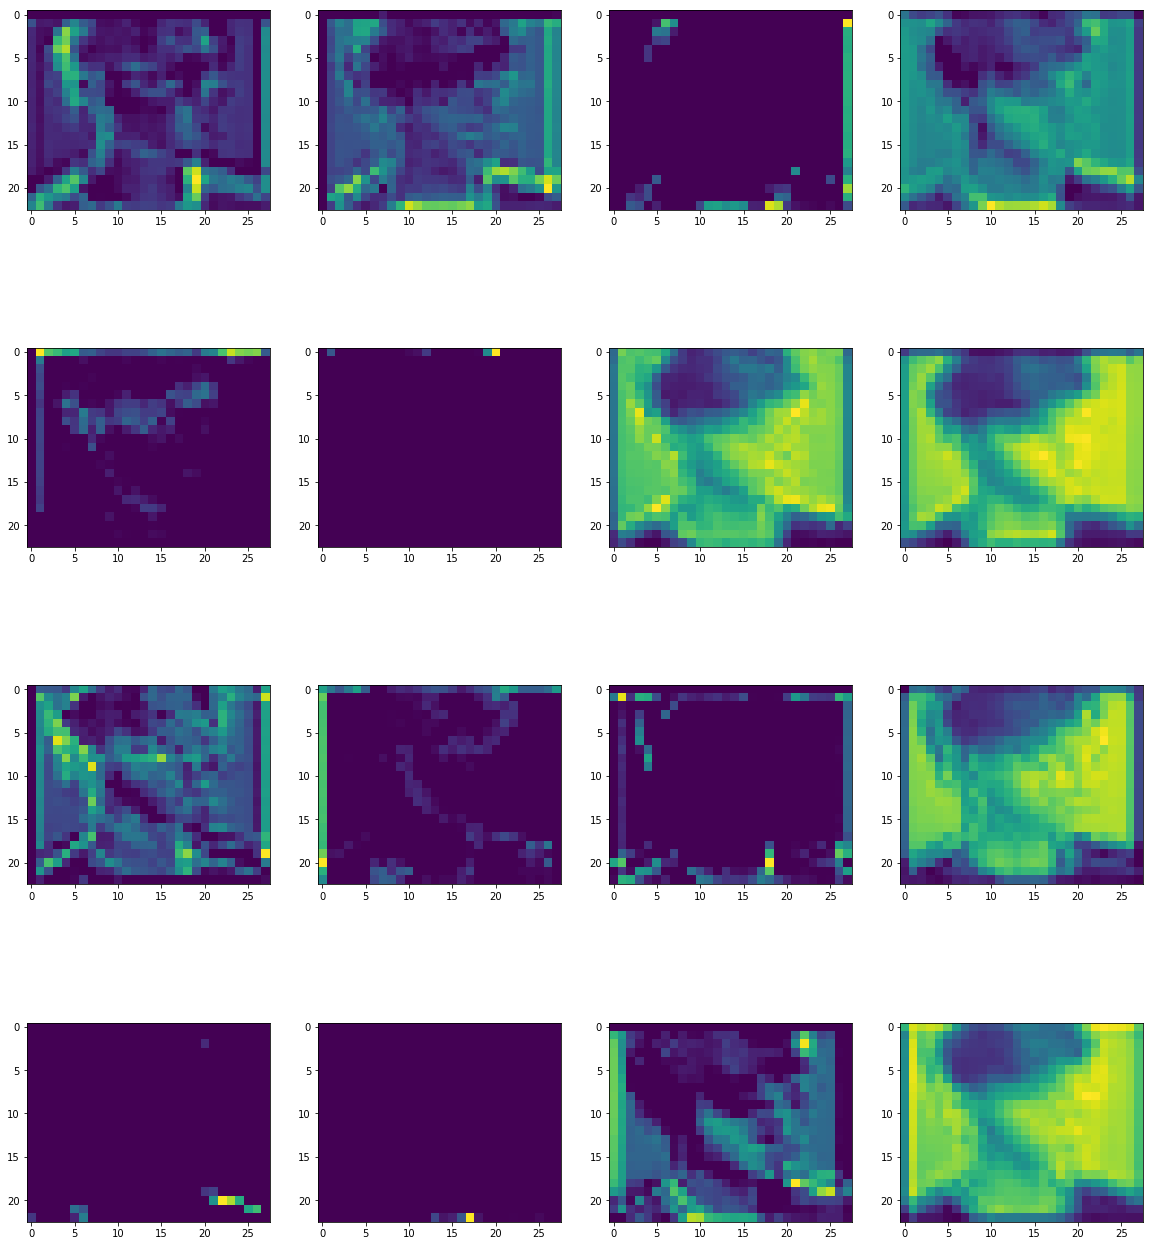

In [8]:
outt=np.array(conv3_output)
print(outt.shape)

plt.figure(figsize=(20,30))
columns = 4
for i in range(16):
    plt.subplot(16 / columns + 1, columns, i + 1)
    plt.imshow(outt[0,1,:,:,i])
plt.show()   

(10, 92, 112, 32)


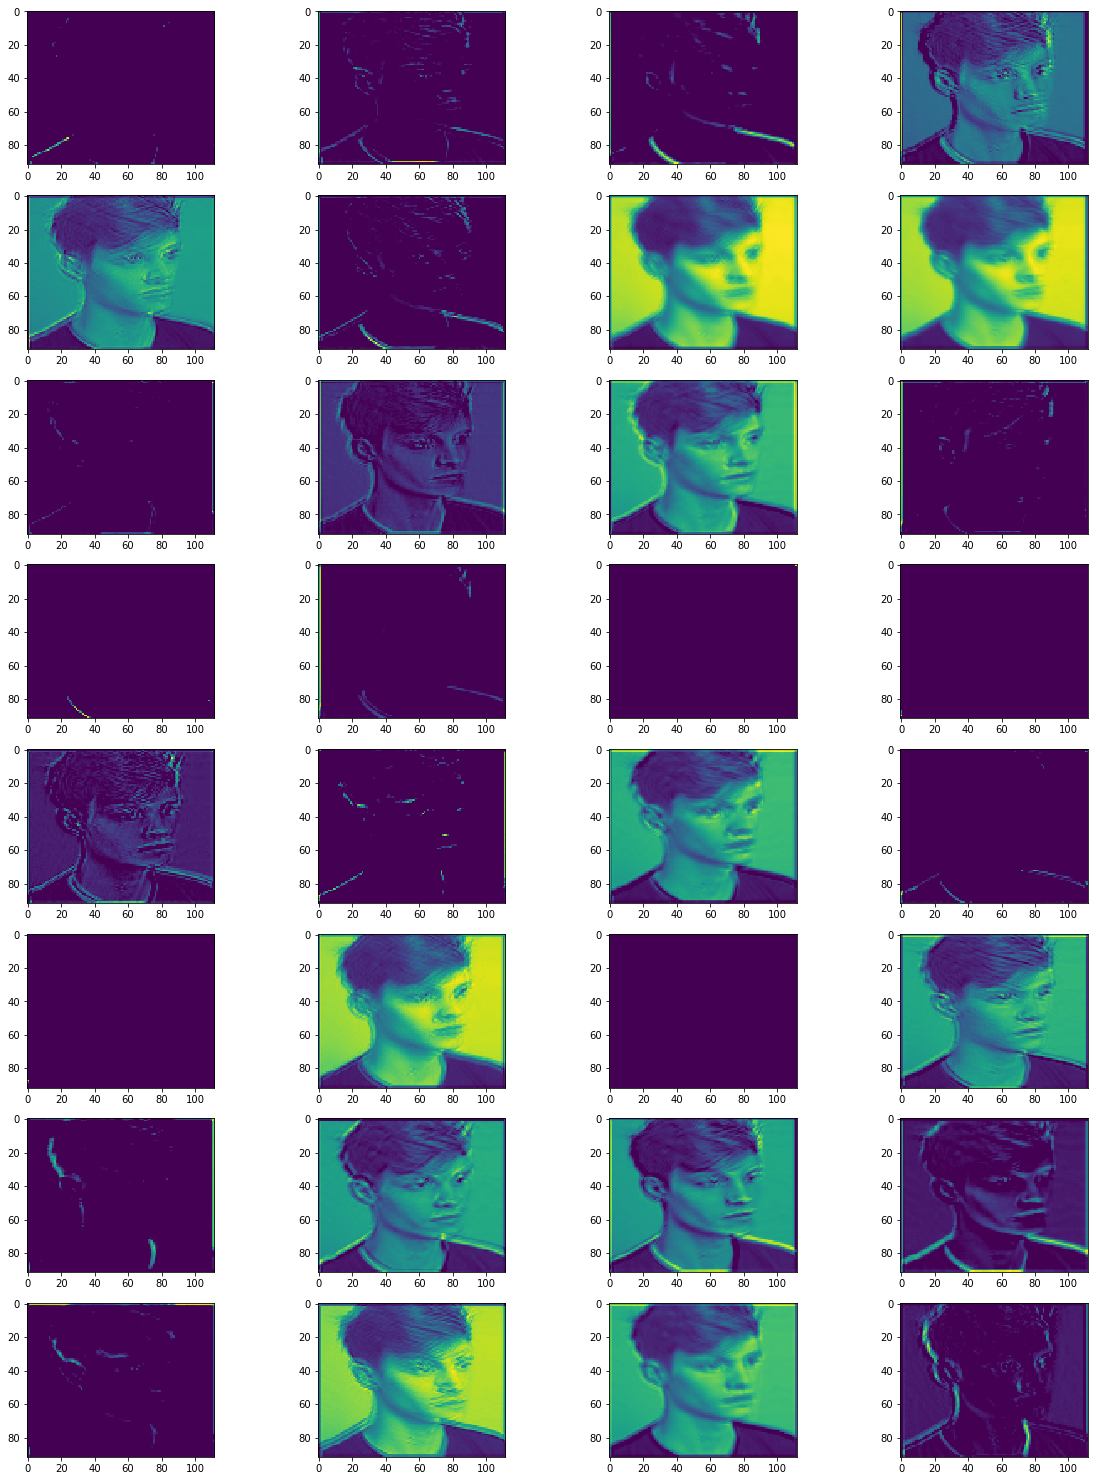

In [9]:
session = tf.InteractiveSession()
tf.global_variables_initializer().run()
con=session.run(conv_output,feed_dict={x:images2})
outt=np.array(con)
print(outt.shape)

plt.figure(figsize=(20,30))
columns = 4
for i in range(32):
    plt.subplot(32 / columns + 1, columns, i + 1)
    plt.imshow(outt[1,:,:,i])
plt.show()   